# Generate weather music for phase 3 sonification evaluation

Generate the weather music for extreme weathers
- Highest and lowest temperatures
- Highest rainfall amount
- Highest snowfall amount
- Strongest wind
- Driest
- Totally calm weather (blue sky, calm wind, mild temperature, moderate humidity)

In [ ]:
import os
import pandas as pd
from datetime import datetime
from common.common_weather import display_1h_weather
from model.WeatherMusicAssociation import WeatherMusicAssociationModel
from model.WeatherSonification import generate_music_of_hour
from common import common

In [2]:
common.init_notebook()

In [3]:
weather_vae_out = common.data_path("weather_vae_out")
midi_dir = common.data_path("midi_for_evaluation_2")
os.makedirs(midi_dir, exist_ok=True)

In [4]:
# Set the same value as result_interval_hours in 9-WeatherMusicAssociation.ipynb.
delta_hour = 1

key_encoding = "onehot"

In [5]:
# If True, the files are shuffled so that the listener cannot identify what weather is sonified.
shuffle = True

In [6]:
model = WeatherMusicAssociationModel(key_encoding)
model.load_trained_models()
df = model.load_weather_music_features()

In [7]:
# Display the weather of the forecast date.
weather_vae = model.weather_vae
encoder_loaded = weather_vae.encoder
weather_df = weather_vae.load_nwp_data()

# TODO This weather parameter has been calculated different locations. Do it once.
weather_df['cloud_amount_of_low_mid_clouds'] = (weather_df['cloud_amount_of_low_cloud'] + weather_df['cloud_amount_of_medium_cloud']) / 2
weather_params = ['temperature_at_screen_level', 'relative_humidity_at_screen_level', 'rainfall_accumulation-PT01H', 'wind_speed_at_10m', 'cloud_amount_of_low_mid_clouds']

df['date_time'] = df['date_time'].astype(str)


In [8]:
# This file is generated in 1-1 CVAE K-means clustering of latent space.
clustered_df = pd.read_csv(f"{weather_vae_out}/clustered_hourly_weather.csv")

In [9]:
clustered_df.columns

Index(['Unnamed: 0', 'date_time', 'y', 'x', 'cloud_amount_of_high_cloud',
       'cloud_amount_of_low_cloud', 'cloud_amount_of_medium_cloud',
       'cloud_amount_of_total_cloud', 'fog_fraction_at_screen_level',
       'pressure_at_surface', 'relative_humidity_at_screen_level',
       'temperature_at_screen_level', 'visibility_at_screen_level',
       'rainfall_accumulation-PT01H', 'snowfall_accumulation-PT01H', 'wx',
       'wy', 'month', 'hour', 'cluster', 'distance',
       'cloud_amount_of_low_mid_clouds', 'rainfall_mm', 'snowfall_mm',
       'wind_speed', 'wind_direction'],
      dtype='object')

### Define functions

In [10]:
def display_music_features(forecast_date, df):
  print(df[df['date_time'] == forecast_date.strftime("%Y%m%d%H")])

def display_sonification(forecast_date):
  music_of_day, midi_path = generate_music_of_hour(forecast_date, df)
  music_of_day.show()
  display_1h_weather(weather_df, forecast_date, weather_params)
  display_music_features(forecast_date, df)
  return midi_path

### Highest and Lowest temperatures

In [11]:
high_temp_df = clustered_df.sort_values(['temperature_at_screen_level'], ascending=False).head(5)
high_temp_df['pattern'] = 'High_temperature'
low_temp_df = clustered_df.sort_values(['temperature_at_screen_level']).head(5)
low_temp_df['pattern'] = 'Low_temperature'


In [12]:
high_temp_df['temperature_at_screen_level'] - 273

4516    25.703125
6031    25.554688
3944    25.468750
3943    25.367188
4184    25.234375
Name: temperature_at_screen_level, dtype: float64

In [13]:
low_temp_df['temperature_at_screen_level'] - 273

1585   -4.437500
1586   -4.398438
1584   -4.101562
1583   -3.625000
1582   -3.320312
Name: temperature_at_screen_level, dtype: float64

### Highest rainfall amount

In [14]:
high_rain_df = clustered_df.sort_values(['rainfall_mm'], ascending=False).head(5)
high_rain_df['pattern'] = 'High_rain'

### Highest snowfall amount

In [15]:
high_snow_df = clustered_df.sort_values(['snowfall_mm'], ascending=False).head(5)
high_snow_df['pattern'] = 'High_snow'

### Strongest wind

In [16]:
high_wind_df = clustered_df.sort_values(['wind_speed'], ascending=False).head(5)
high_wind_df['pattern'] = 'High_wind'

In [17]:
weather_cols = ['fog_fraction_at_screen_level',
       'relative_humidity_at_screen_level',
       'temperature_at_screen_level',
       'cloud_amount_of_low_mid_clouds', 'rainfall_mm', 'snowfall_mm',
       'wind_speed', 'wind_direction']

high_wind_df[weather_cols]

,fog_fraction_at_screen_level,relative_humidity_at_screen_level,temperature_at_screen_level,cloud_amount_of_low_mid_clouds,rainfall_mm,snowfall_mm,wind_speed,wind_direction
125,0.0,0.745117,280.210938,0.406250,0,0.0,14.0625,234.8125
8486,0.0,0.823242,284.078125,0.863281,0,0.0,13.1250,260.1875
7821,0.0,0.837891,285.945312,0.664062,0,0.0,13.0000,261.0000
8488,0.0,0.814453,284.546875,0.683594,0,0.0,12.7500,261.5625
330,0.0,0.932617,276.062500,0.660156,4,0.0,12.7500,231.8750


### Driest

In [18]:
dry_df = clustered_df.sort_values(['relative_humidity_at_screen_level'], ascending=True).head(5)
dry_df['pattern'] = 'Dry'

### Comfortable weather (blue sky, calm wind, mild temperature, moderate humidity)

In [19]:
mild_temp = (clustered_df['temperature_at_screen_level'] >= 273+10) & (clustered_df['temperature_at_screen_level'] < 273+15)
moderate_rh = (clustered_df['relative_humidity_at_screen_level'] >= 0.4) & (clustered_df['relative_humidity_at_screen_level'] < 0.6)

comfortable_weather_df = clustered_df[mild_temp & moderate_rh].sort_values([
  'cloud_amount_of_total_cloud',
  'wind_speed',
  ], ascending=[
    True,
    True,
  ]).head(5)

comfortable_weather_df['pattern'] = 'Comfortable'

### Cold windy weather

In [20]:
cold_temp = clustered_df['temperature_at_screen_level'] < 273 # 0 degrees celsius

cold_windy_df = clustered_df[cold_temp].sort_values(['wind_speed'], ascending=False).head(5)
cold_windy_df['pattern'] = 'Cold_windy'

### Generate the music for the selected weathers

In [21]:
def generate_music_for_selected_weathers(mydf):
  mydf = mydf.sample(frac=1).reset_index(drop=True)
  mydf['date_time'] = [str(dt) for dt in mydf['date_time']]
  # Merge df and output csv. df is a global variable.
  pd.merge(mydf, df, on='date_time', how='left').to_csv(f"{midi_dir}/samples.csv")

  # Generate MIDI files
  forecast_dates = [datetime.strptime(dt_str, "%Y%m%d%H") for dt_str in mydf['date_time']]
  for i, forecast_date in enumerate(forecast_dates):
    print(f"Sonification for {forecast_date.strftime('%Y%m%d %H:00')} ================================")
    midi_path = display_sonification(forecast_date)
    os.rename(midi_path, f"{midi_dir}/%02d.mid" % i)

Sonification for 20230420 17:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:35:53.879112: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:35:53.879227: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:35:53.879318: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:35:53.879609: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:35:53.879653: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:35:53.879

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143553_1.mid
key_str = C num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


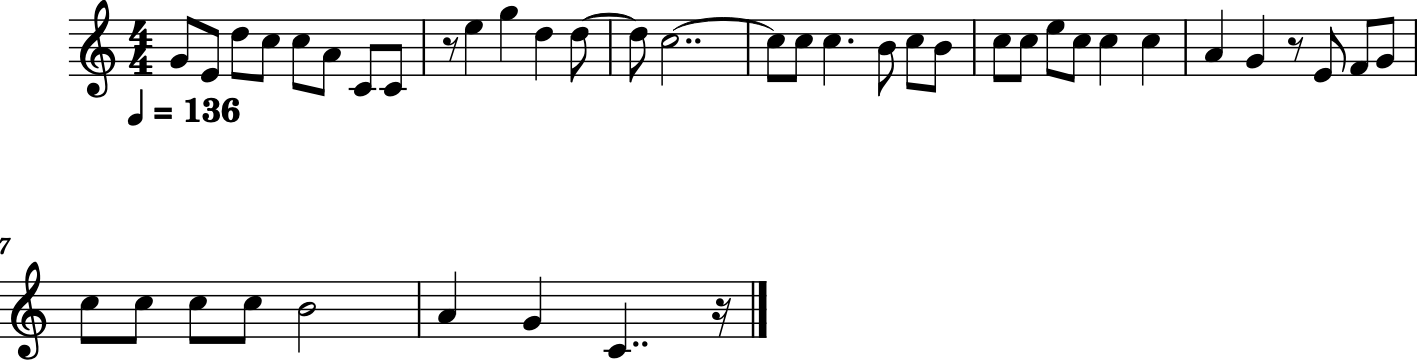

Numerical weather forecast from 2023042017 to 2023042018
temperature_at_screen_level          284.007812
relative_humidity_at_screen_level      0.526367
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      5.687500
cloud_amount_of_low_mid_clouds         0.000000
dtype: float64
      mean_note_duration     tempo  pitch_range  mode  Valence   Arousal  \
2627            0.646344  136.5811    47.625992   1.0   0.7306  0.580496   

       date_time mode_str  c5_index  c5_index_int  
2627  2023042017    major         2             2  
Sonification for 20230116 02:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:00.014347: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:00.014435: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:00.014514: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:00.014782: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:00.014816: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:00.014

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143600_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


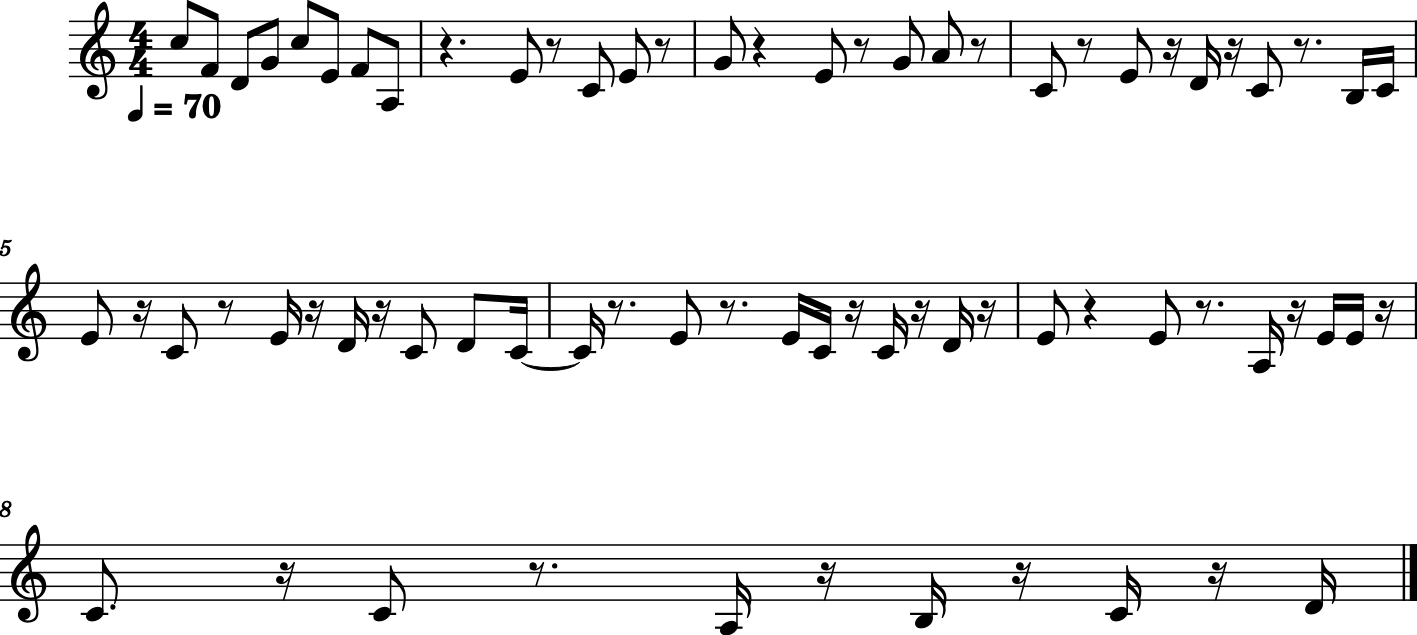

Numerical weather forecast from 2023011602 to 2023011603
temperature_at_screen_level          273.28125
relative_humidity_at_screen_level      1.00000
rainfall_accumulation-PT01H            0.00000
wind_speed_at_10m                      2.81250
cloud_amount_of_low_mid_clouds         1.00000
dtype: float64
     mean_note_duration      tempo  pitch_range      mode   Valence   Arousal  \
361            0.724059  70.209381    45.843777  0.000107  0.338251  0.284255   

      date_time mode_str  c5_index  c5_index_int  
361  2023011602    minor         8             8  
Sonification for 20230506 15:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:04.116964: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:04.117079: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:04.117178: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:04.117534: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:04.117571: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:04.117

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143604_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


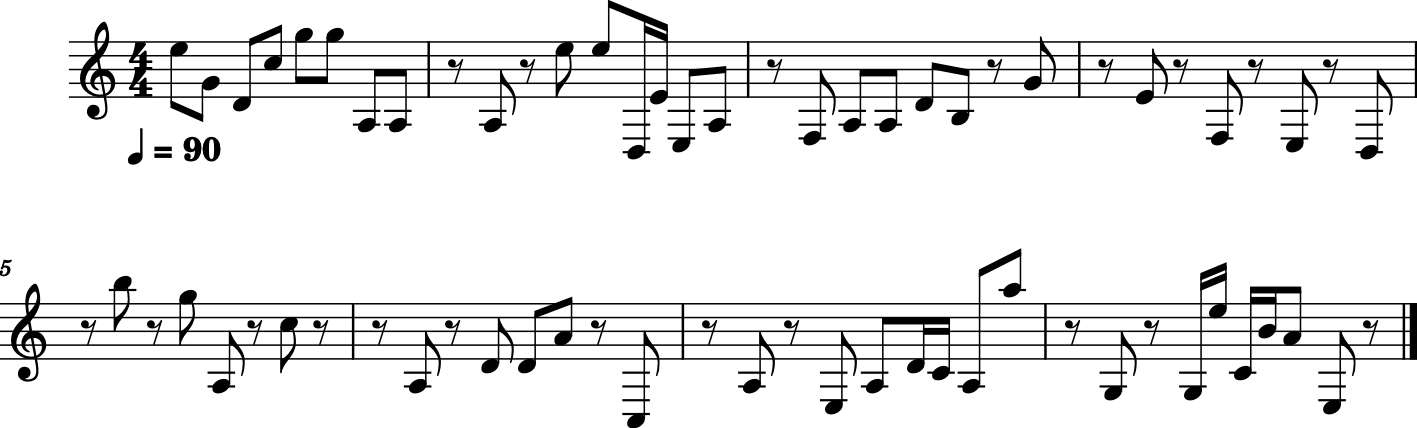

Numerical weather forecast from 2023050615 to 2023050616
temperature_at_screen_level          283.750000
relative_humidity_at_screen_level      0.941406
rainfall_accumulation-PT01H            0.005601
wind_speed_at_10m                      1.375000
cloud_amount_of_low_mid_clouds         0.968750
dtype: float64
      mean_note_duration      tempo  pitch_range      mode   Valence  \
3008            0.591609  90.646172    57.845589  0.000142  0.470177   

       Arousal   date_time mode_str  c5_index  c5_index_int  
3008  0.466524  2023050615    minor         3             3  
Sonification for 20230116 12:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:07.943986: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:07.944074: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:07.944157: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:07.944425: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:07.944459: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:07.944

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143607_1.mid
key_str = C num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


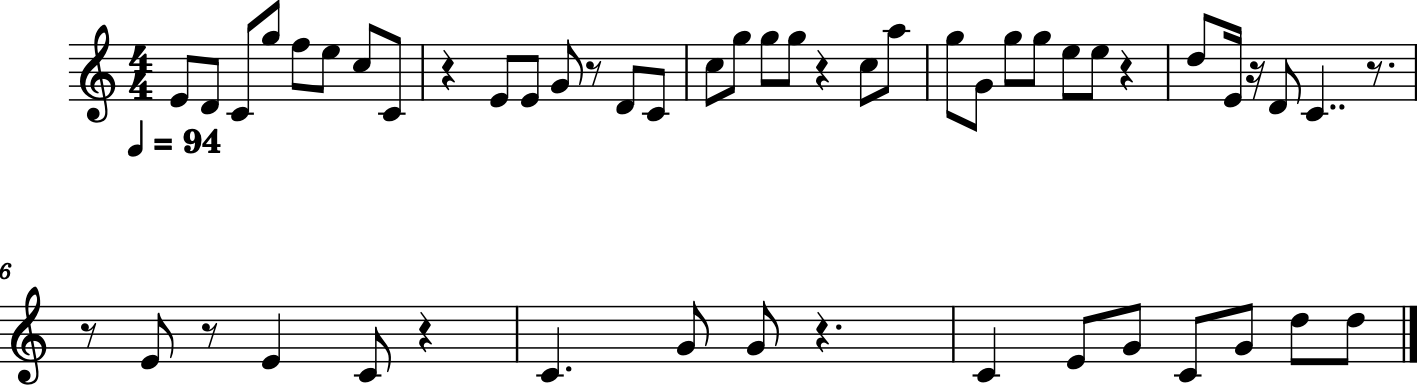

Numerical weather forecast from 2023011612 to 2023011613
temperature_at_screen_level          272.945312
relative_humidity_at_screen_level      0.745117
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      4.937500
cloud_amount_of_low_mid_clouds         0.000000
dtype: float64
     mean_note_duration      tempo  pitch_range  mode   Valence   Arousal  \
371            0.512676  94.525558    49.722778   1.0  0.633721  0.545055   

      date_time mode_str  c5_index  c5_index_int  
371  2023011612    major         8             8  
Sonification for 20230311 23:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:11.853325: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:11.853425: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:11.853513: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:11.853869: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:11.853912: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:11.853

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143611_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


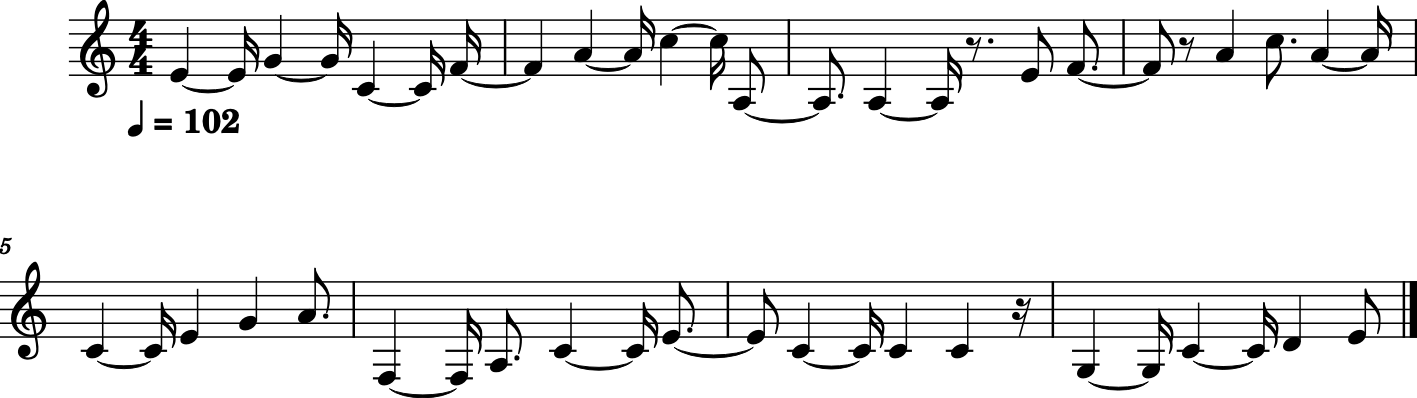

Numerical weather forecast from 2023031123 to 2023031200
temperature_at_screen_level          275.101562
relative_humidity_at_screen_level      0.797852
rainfall_accumulation-PT01H            0.000441
wind_speed_at_10m                      2.937500
cloud_amount_of_low_mid_clouds         1.000000
dtype: float64
      mean_note_duration       tempo  pitch_range          mode   Valence  \
1674             1.29362  102.554451     39.28326  1.697920e-07  0.231747   

       Arousal   date_time mode_str  c5_index  c5_index_int  
1674  0.237532  2023031123    minor         8             8  
Sonification for 20230116 03:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:15.739573: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:15.739661: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:15.739743: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:15.740045: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:15.740079: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:15.740

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143615_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


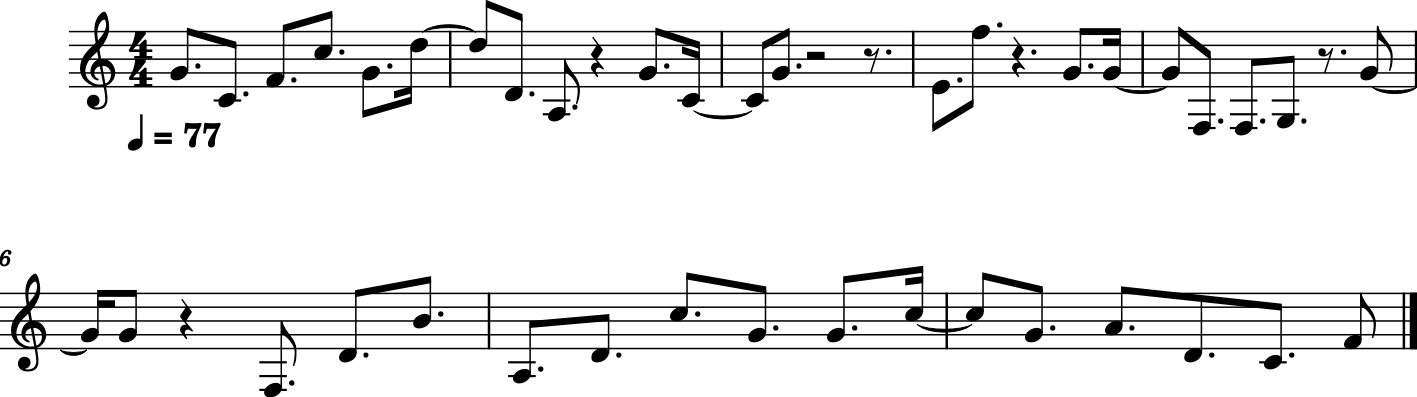

Numerical weather forecast from 2023011603 to 2023011604
temperature_at_screen_level          272.867188
relative_humidity_at_screen_level      1.002930
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      4.062500
cloud_amount_of_low_mid_clouds         1.000000
dtype: float64
     mean_note_duration      tempo  pitch_range      mode   Valence   Arousal  \
362            0.887322  77.553589    45.880775  0.000059  0.313872  0.260168   

      date_time mode_str  c5_index  c5_index_int  
362  2023011603    minor         8             8  
Sonification for 20230119 07:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:19.552646: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:19.552736: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:19.552815: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:19.553099: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:19.553132: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:19.553

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143619_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


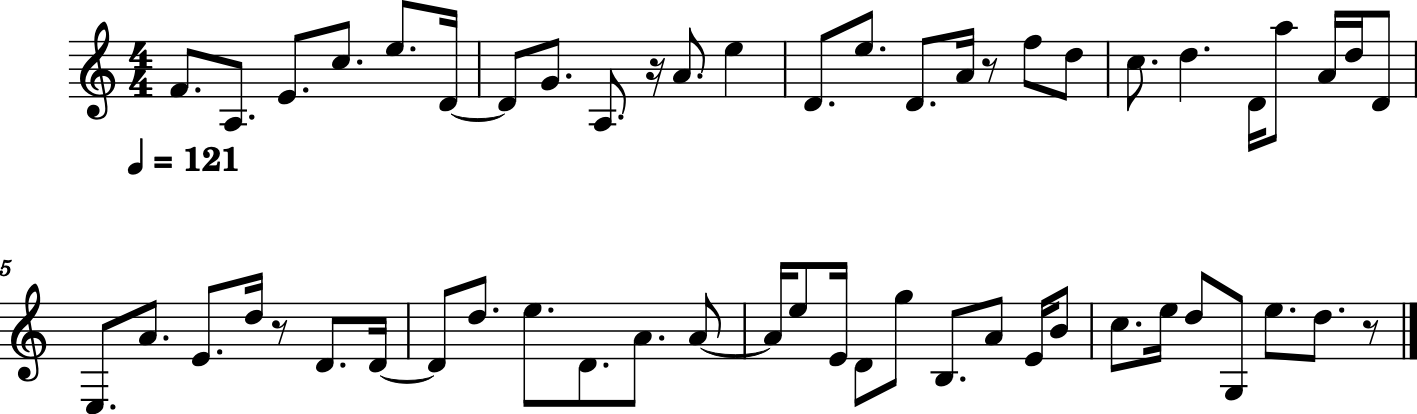

Numerical weather forecast from 2023011907 to 2023011908
temperature_at_screen_level          272.296875
relative_humidity_at_screen_level      0.869141
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      4.937500
cloud_amount_of_low_mid_clouds         0.007812
dtype: float64
     mean_note_duration       tempo  pitch_range          mode   Valence  \
437            0.813245  121.977371    46.031467  3.697211e-08  0.437538   

      Arousal   date_time mode_str  c5_index  c5_index_int  
437  0.518402  2023011907    minor         3             3  
Sonification for 20230407 17:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:23.412475: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:23.412561: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:23.412640: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:23.412923: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:23.412960: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:23.412

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143623_1.mid
key_str = C num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


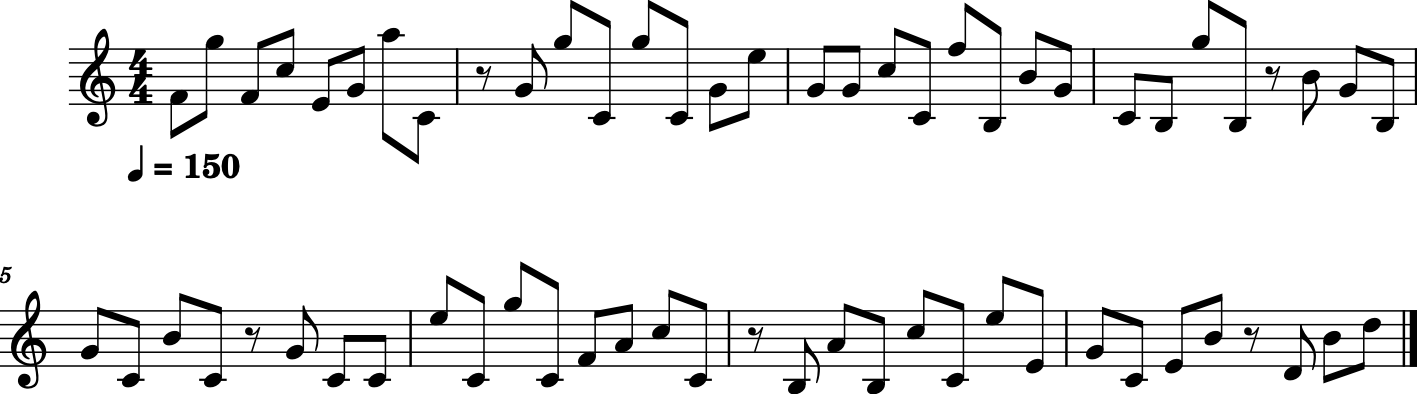

Numerical weather forecast from 2023040717 to 2023040718
temperature_at_screen_level          283.65625
relative_humidity_at_screen_level      0.55957
rainfall_accumulation-PT01H            0.00000
wind_speed_at_10m                      3.81250
cloud_amount_of_low_mid_clouds         0.00000
dtype: float64
      mean_note_duration       tempo  pitch_range  mode  Valence   Arousal  \
2315            0.595149  150.700562    48.319393   1.0  0.75637  0.650441   

       date_time mode_str  c5_index  c5_index_int  
2315  2023040717    major         2             2  
Sonification for 20230619 01:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:27.562286: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:27.562393: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:27.562478: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:27.563014: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:27.563115: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:27.563

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143627_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


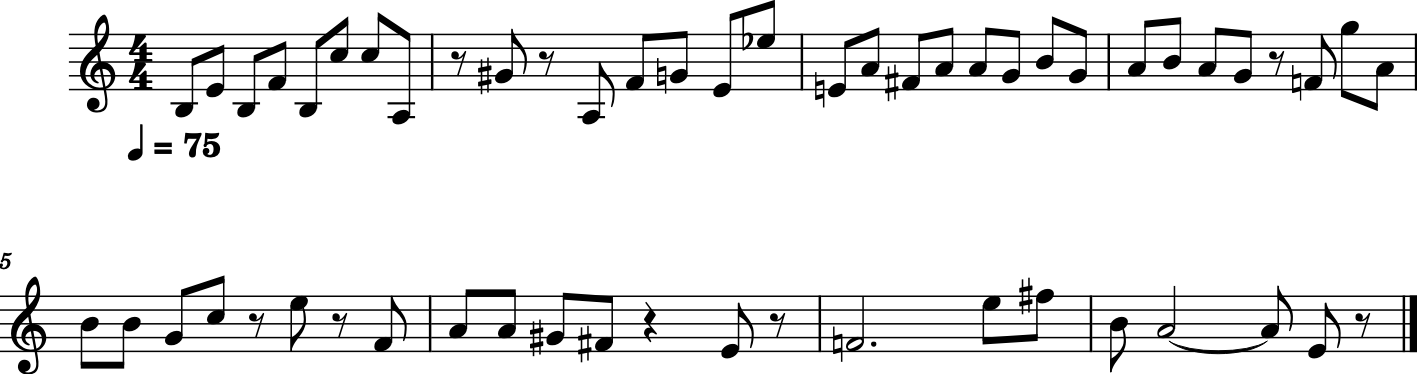

Numerical weather forecast from 2023061901 to 2023061902
temperature_at_screen_level          287.921875
relative_humidity_at_screen_level      0.976562
rainfall_accumulation-PT01H            0.007903
wind_speed_at_10m                      5.187500
cloud_amount_of_low_mid_clouds         0.949219
dtype: float64
      mean_note_duration      tempo  pitch_range          mode   Valence  \
4050            0.688957  75.287544    35.533302  5.487529e-07  0.326361   

      Arousal   date_time mode_str  c5_index  c5_index_int  
4050  0.33332  2023061901    minor         8             8  
Sonification for 20230119 09:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:31.545007: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:31.545122: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:31.545386: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:31.546351: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:31.546465: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:31.546

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143631_1.mid
key_str = C num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


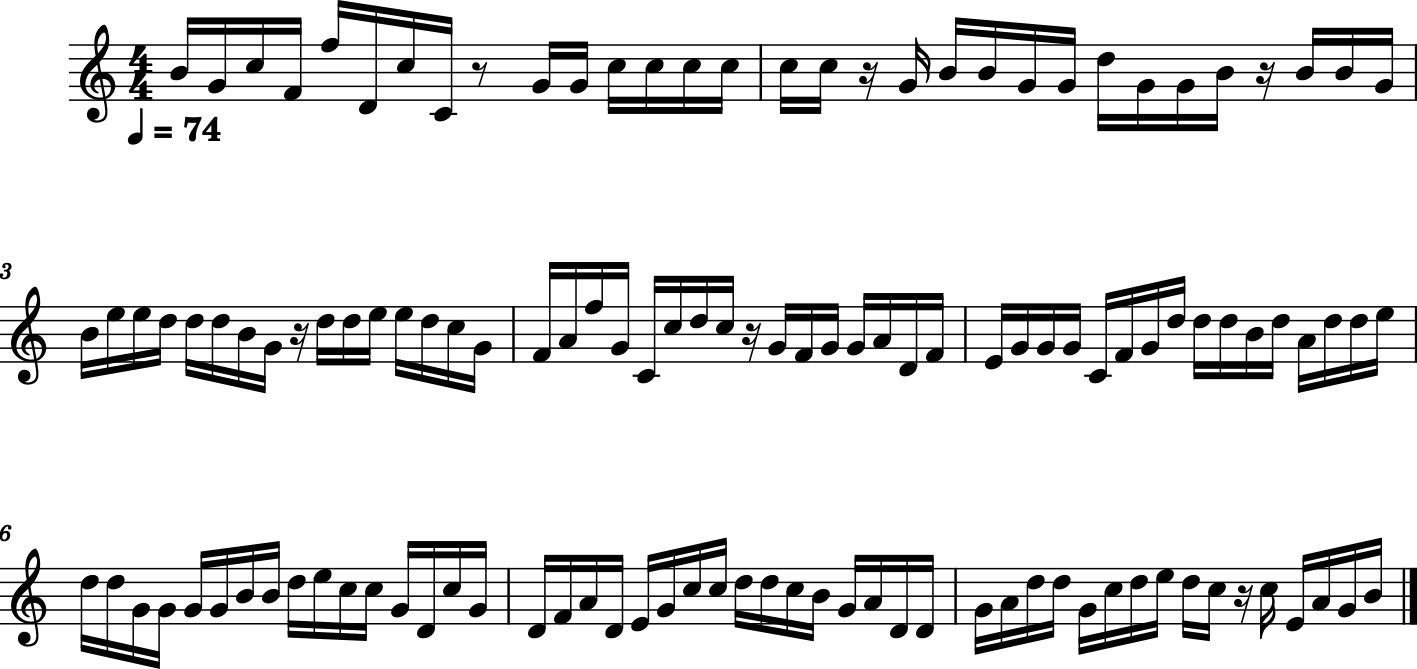

Numerical weather forecast from 2023011909 to 2023011910
temperature_at_screen_level          272.625000
relative_humidity_at_screen_level      0.854492
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      5.250000
cloud_amount_of_low_mid_clouds         0.000000
dtype: float64
     mean_note_duration      tempo  pitch_range      mode   Valence   Arousal  \
439             0.45522  74.412262    49.752361  0.999998  0.569137  0.467852   

      date_time mode_str  c5_index  c5_index_int  
439  2023011909    major         8             8  
Sonification for 20230117 11:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:35.775070: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:35.775188: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:35.775294: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:35.775600: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:35.775640: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:35.775

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143635_1.mid
key_str = C num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


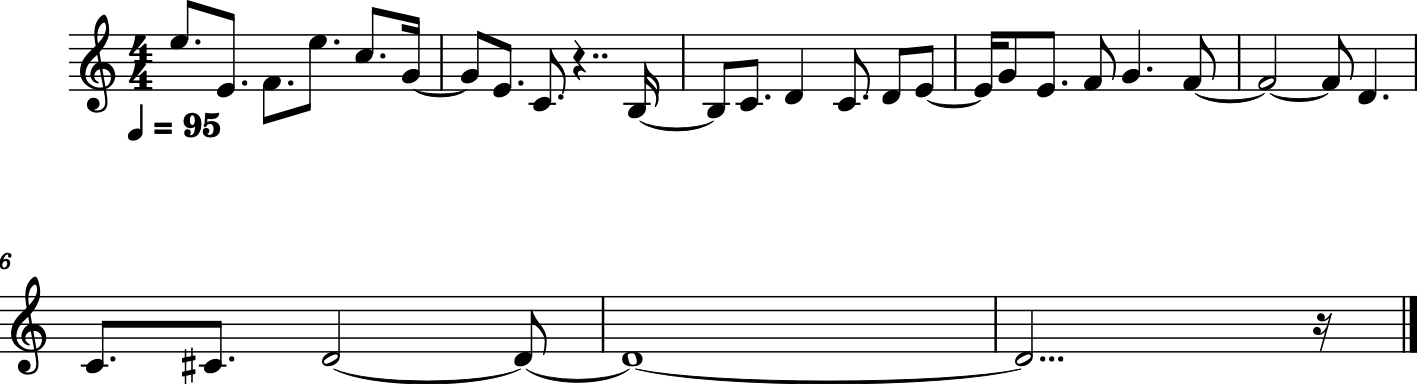

Numerical weather forecast from 2023011711 to 2023011712
temperature_at_screen_level          272.843750
relative_humidity_at_screen_level      0.801758
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      5.187500
cloud_amount_of_low_mid_clouds         0.042969
dtype: float64
     mean_note_duration      tempo  pitch_range  mode   Valence   Arousal  \
394             0.84653  95.939705    36.698883   1.0  0.487559  0.256958   

      date_time mode_str  c5_index  c5_index_int  
394  2023011711    major         8             8  
Sonification for 20230116 01:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:39.666429: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:39.666516: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:39.666595: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:39.666865: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:39.666899: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:39.666

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143639_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


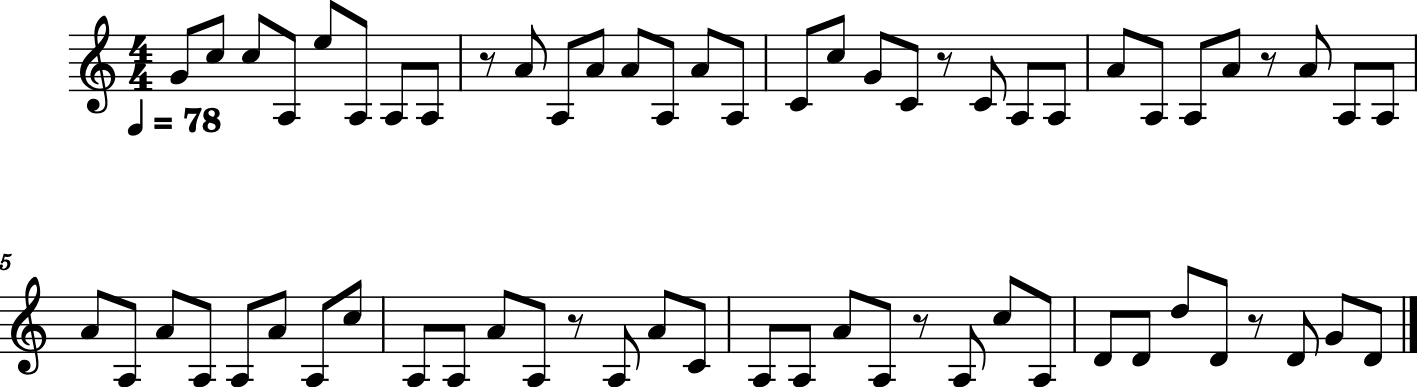

Numerical weather forecast from 2023011601 to 2023011602
temperature_at_screen_level          274.234375
relative_humidity_at_screen_level      0.932617
rainfall_accumulation-PT01H            0.000144
wind_speed_at_10m                      2.562500
cloud_amount_of_low_mid_clouds         1.000000
dtype: float64
     mean_note_duration      tempo  pitch_range      mode   Valence   Arousal  \
360            0.528634  78.421913    63.191544  0.005556  0.482478  0.455378   

      date_time mode_str  c5_index  c5_index_int  
360  2023011601    minor        11            11  
Sonification for 20230407 14:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:43.579259: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:43.579343: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:43.579421: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:43.579683: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:43.579717: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:43.579

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143643_1.mid
key_str = C num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


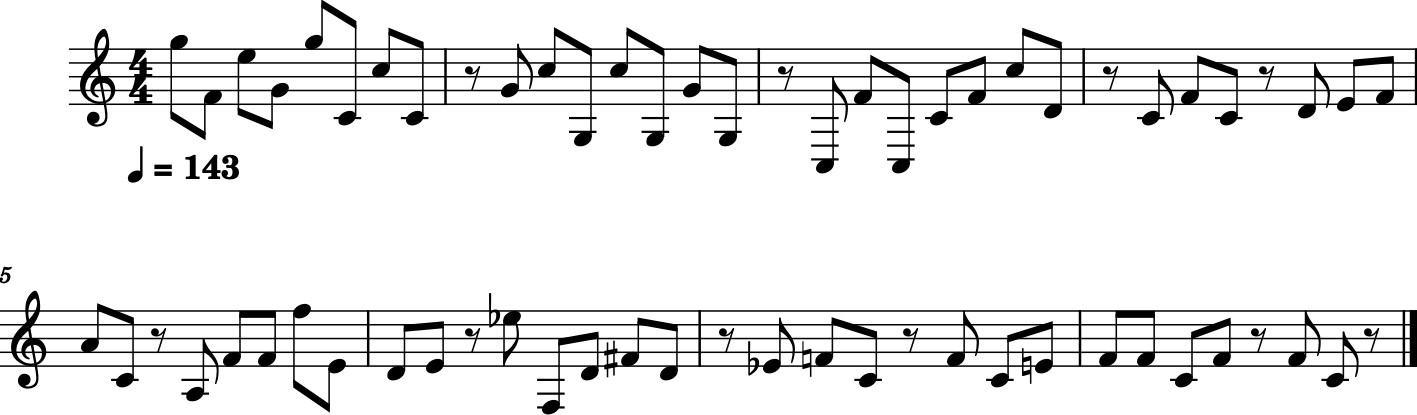

Numerical weather forecast from 2023040714 to 2023040715
temperature_at_screen_level          284.164062
relative_humidity_at_screen_level      0.507812
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      3.125000
cloud_amount_of_low_mid_clouds         0.000000
dtype: float64
      mean_note_duration       tempo  pitch_range  mode   Valence   Arousal  \
2312            0.543195  143.679718    47.898678   1.0  0.740412  0.659386   

       date_time mode_str  c5_index  c5_index_int  
2312  2023040714    major         2             2  
Sonification for 20230615 01:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:47.423793: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:47.423886: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:47.423973: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:47.424255: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:47.424291: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:47.424

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143647_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


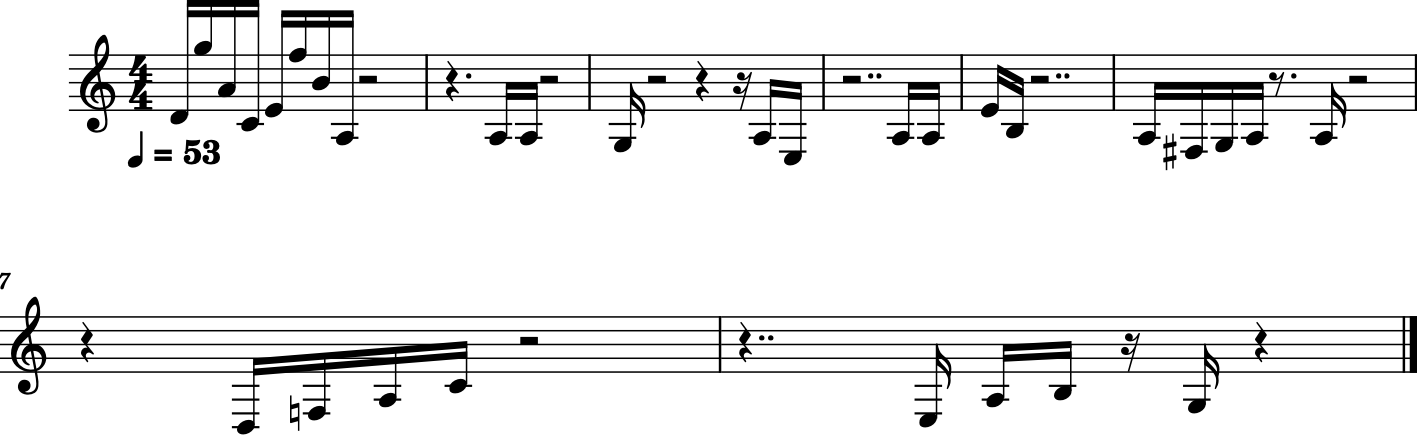

Numerical weather forecast from 2023061501 to 2023061502
temperature_at_screen_level          287.023438
relative_humidity_at_screen_level      0.578125
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      2.437500
cloud_amount_of_low_mid_clouds         0.000000
dtype: float64
      mean_note_duration      tempo  pitch_range      mode  Valence   Arousal  \
3954            0.379518  53.744015    52.793293  0.024162   0.4284  0.363461   

       date_time mode_str  c5_index  c5_index_int  
3954  2023061501    minor         8             8  
Sonification for 20230313 11:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:51.283777: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:51.283873: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:51.283951: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:51.284272: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:51.284305: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:51.284

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143651_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


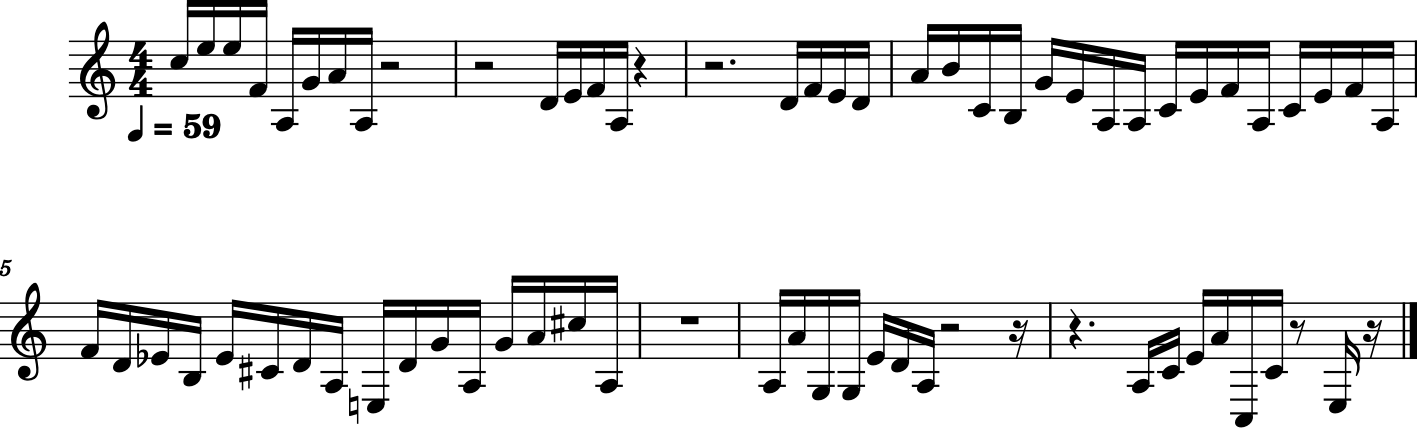

Numerical weather forecast from 2023031311 to 2023031312
temperature_at_screen_level          278.765625
relative_humidity_at_screen_level      0.921875
rainfall_accumulation-PT01H            0.005021
wind_speed_at_10m                      2.625000
cloud_amount_of_low_mid_clouds         1.000000
dtype: float64
      mean_note_duration     tempo  pitch_range      mode   Valence   Arousal  \
1710             0.37881  59.35154    47.141079  0.000389  0.410784  0.367314   

       date_time mode_str  c5_index  c5_index_int  
1710  2023031311    minor         8             8  
Sonification for 20230618 22:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:55.302098: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:55.302202: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:55.302294: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:55.302609: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:55.302642: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:55.302

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143655_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


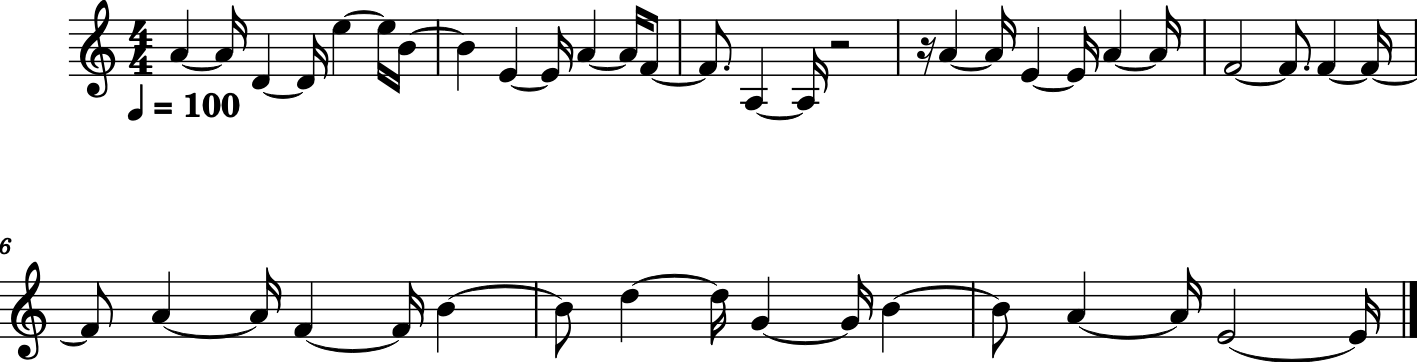

Numerical weather forecast from 2023061822 to 2023061823
temperature_at_screen_level          288.117188
relative_humidity_at_screen_level      0.970703
rainfall_accumulation-PT01H            0.006516
wind_speed_at_10m                      4.750000
cloud_amount_of_low_mid_clouds         0.929688
dtype: float64
      mean_note_duration       tempo  pitch_range      mode   Valence  \
4047            1.285286  100.539177    42.706615  0.000001  0.244986   

       Arousal   date_time mode_str  c5_index  c5_index_int  
4047  0.227734  2023061822    minor         8             8  
Sonification for 20230308 18:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:36:59.166203: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:36:59.166292: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:36:59.166371: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:36:59.166721: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:36:59.166764: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:36:59.166

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143659_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


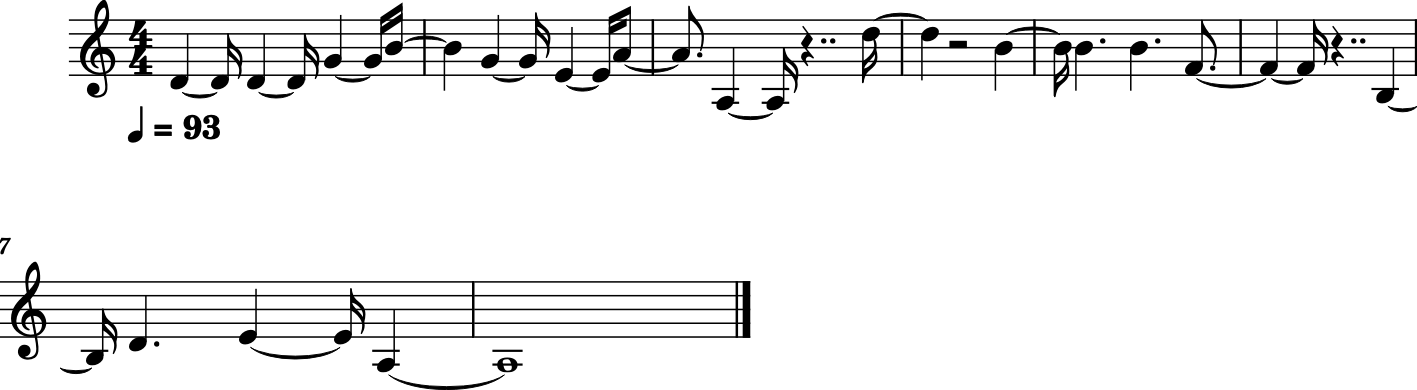

Numerical weather forecast from 2023030818 to 2023030819
temperature_at_screen_level          273.125000
relative_humidity_at_screen_level      0.989258
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      4.562500
cloud_amount_of_low_mid_clouds         0.750000
dtype: float64
      mean_note_duration      tempo  pitch_range      mode  Valence  Arousal  \
1597             1.43734  93.734726    41.952518  0.000002  0.23177  0.19975   

       date_time mode_str  c5_index  c5_index_int  
1597  2023030818    minor         8             8  
Sonification for 20230117 10:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:37:03.185484: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:37:03.185589: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:37:03.185667: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:37:03.185945: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:37:03.185979: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:37:03.186

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143703_1.mid
key_str = C num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


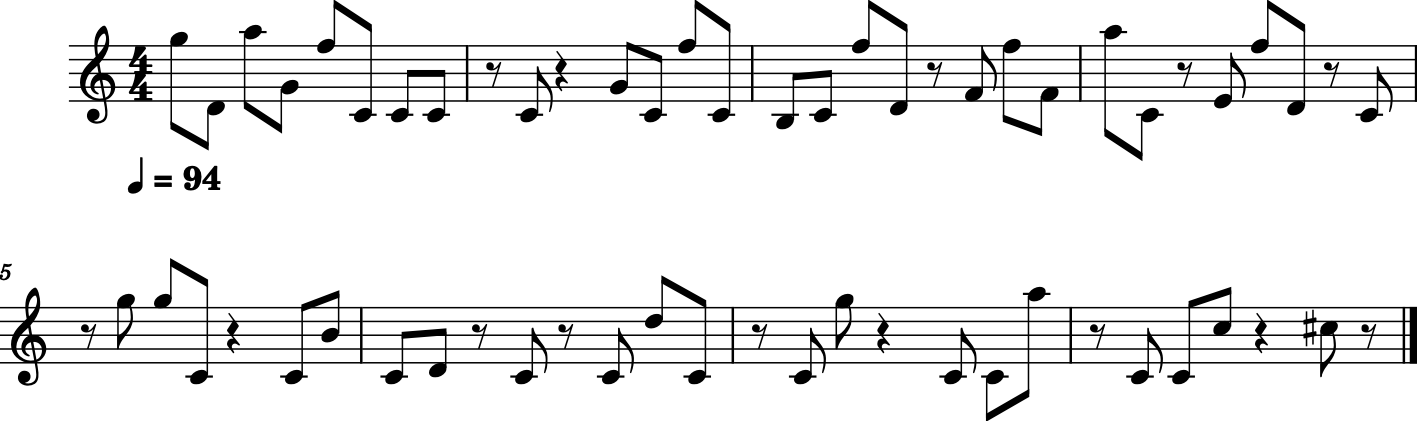

Numerical weather forecast from 2023011710 to 2023011711
temperature_at_screen_level          271.656250
relative_humidity_at_screen_level      0.825195
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      4.937500
cloud_amount_of_low_mid_clouds         0.000000
dtype: float64
     mean_note_duration      tempo  pitch_range  mode   Valence  Arousal  \
393            0.557196  94.769066    45.924572   1.0  0.615023  0.48031   

      date_time mode_str  c5_index  c5_index_int  
393  2023011710    major         8             8  
Sonification for 20231228 22:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:37:07.516055: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:37:07.516656: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:37:07.516770: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:37:07.517093: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:37:07.517130: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:37:07.517

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143707_1.mid
key_str = a num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


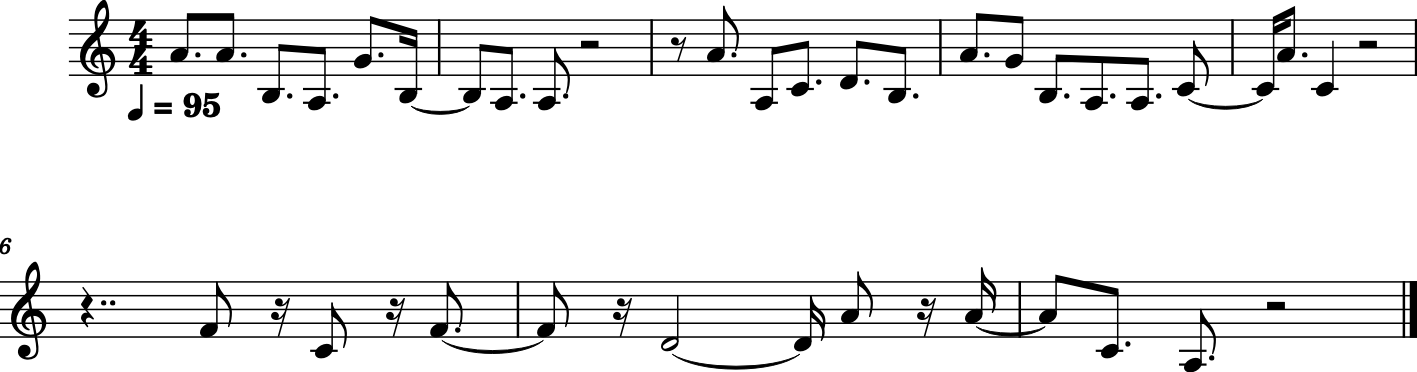

Numerical weather forecast from 2023122822 to 2023122823
temperature_at_screen_level          278.710938
relative_humidity_at_screen_level      0.883789
rainfall_accumulation-PT01H            0.005211
wind_speed_at_10m                      8.437500
cloud_amount_of_low_mid_clouds         1.000000
dtype: float64
      mean_note_duration      tempo  pitch_range          mode   Valence  \
8674            0.897744  95.091995    29.358768  7.340350e-09  0.279729   

       Arousal   date_time mode_str  c5_index  c5_index_int  
8674  0.342722  2023122822    minor         8             8  
Sonification for 20231022 13:00 ================================


Instructions for updating:
non-resource variables are not supported in the long term
2025-10-14 14:37:11.380339: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArray is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayV3.
2025-10-14 14:37:11.380427: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayScatter is deprecated. It will cease to work in GraphDef version 19. Use TensorArrayGradV3.
2025-10-14 14:37:11.380503: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayRead is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayReadV3.
2025-10-14 14:37:11.380787: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArrayWrite is deprecated. It will cease to work in GraphDef version 16. Use TensorArrayWriteV3.
2025-10-14 14:37:11.380824: W tensorflow/core/framework/op_def_util.cc:371] Op TensorArraySize is deprecated. It will cease to work in GraphDef version 16. Use TensorArraySizeV3.
2025-10-14 14:37:11.380

Latest MIDI file /Users/nrjmata/Documents/UOE/EvoMusart 2026/weather_sonification_evomusart_2026/src/common/../../data/../magenta-docker/output/2025-10-14_143711_1.mid
key_str = C num of sharps = 0


/Users/nrjmata/tf/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


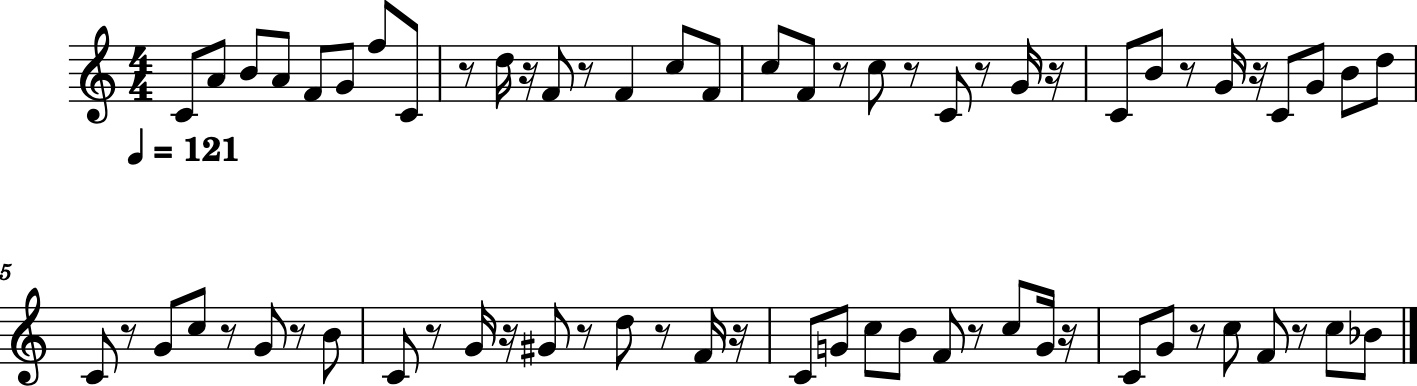

Numerical weather forecast from 2023102213 to 2023102214
temperature_at_screen_level          284.484375
relative_humidity_at_screen_level      0.567383
rainfall_accumulation-PT01H            0.000000
wind_speed_at_10m                      4.125000
cloud_amount_of_low_mid_clouds         0.000000
dtype: float64
      mean_note_duration       tempo  pitch_range  mode   Valence   Arousal  \
7060             0.54953  121.628586    47.224396   1.0  0.696896  0.591112   

       date_time mode_str  c5_index  c5_index_int  
7060  2023102213    major         8             8  


In [22]:
# Concat the dataframes
concat_df = pd.concat([
  # high_temp_df,
  # low_temp_df,
  high_rain_df,
  high_snow_df,
  # high_wind_df,
  # dry_df,
  comfortable_weather_df,
  cold_windy_df
])

generate_music_for_selected_weathers(concat_df)